In [1]:
# importando as bibliotecas necessárias
import numpy as np
import pandas as pd
import os
from os import path
import re

import matplotlib.pyplot as plt
from matplotlib import cm

import seaborn as sns
sns.set_style("whitegrid")

%matplotlib inline

In [2]:
PA = 'PA'
PB = 'PB'
BINOMIAL = 'CL-B'

In [3]:
def modificar_valor_simulacao(nome_diretorio):
    posicao = nome_diretorio.rfind('_')
    posicao += 1
    simulacao = nome_diretorio[posicao:]
    if simulacao == '0.7':
            simulacao = BINOMIAL
    return simulacao

def obter_interfmodel(item):
    interfModel = item[12]
    return int(interfModel)

def obter_repeticao(texto):
    match = re.findall('\d+', texto)
    if match and len(match) == 2:
        nro = match[1]
        return int(nro)
    else:
        raise Exception('Erro ao Identificar a repeticao do registro')

In [4]:
colorMAP = {
    'PA' : '#d62d20',
    'PB' : '#80b0ff',
    'p=0.1' : '#1A66FF',
    'p=0.2' : '#1A66FF',
    'p=0.3' : '#1A66FF',
    'p=0.4' : '#1A66FF',
    'p=0.5' : '#1A66FF',
    'p=0.6' : '#1A66FF',
    'p=0.7' : '#1A66FF',
    'p=0.8' : '#1A66FF',
    'p=0.9' : '#1A66FF',
    'CL-B' : '#FF7F0E'
}

In [5]:
FILE = 'packets_reception_rate_all.txt'

colunas = [
    'Informacoes',
    'nó 1',
    'nó 2',
    'nó 3',
    'nó 4',
    'nó 5'
]

# obtem uma lista de todos arquivos e subdiretorios do diretorio atual
folders = os.listdir()
folders.sort()

# INICIALIZANDO UM DATA FRAME VAZIO
DATA = pd.DataFrame()

# COLETA DOS DADOS
for folder in filter(lambda x: path.isdir(x),folders): #filter seleciona apenas os diretórios
    os.chdir(folder)
    if path.isfile(FILE): # se o arquivo existe no diretório ele processa e faz a coleta
        simulacao = modificar_valor_simulacao(folder)
        dfPRR = pd.read_csv(FILE,delimiter='|',names=colunas)
        dfPRR['Modelo de colisao'] = dfPRR['Informacoes'].apply(obter_interfmodel)
        dfPRR['repeticao'] = dfPRR['Informacoes'].apply(obter_repeticao)
        dfPRR['simulacao'] = simulacao
        DATA = DATA.append(dfPRR,ignore_index=True)
        print('coletado dados de ->\t',folder)
    os.chdir('../')

# Pré-processamento dos dados
DATA = DATA.drop('Informacoes', axis=1)
DATA = DATA[DATA['Modelo de colisao'] != 2]

DATA = DATA.melt(id_vars=['Modelo de colisao', 'repeticao', 'simulacao'],
          value_vars=['nó 1', 'nó 2', 'nó 3', 'nó 4', 'nó 5'],
          var_name='nó sensor',
          value_name = 'PRR'
         )

DATA['PRR'] = DATA['PRR'] * 100
# Exibindo informações do Data Frame
# por padrão ele vai exibir a última função executada
print('\n\n')
DATA.info()
# DATA.sample(5)

coletado dados de ->	 simulacao_4.0.0_PA
coletado dados de ->	 simulacao_4.0.1_PB
coletado dados de ->	 simulacao_4.2.1_CLBin_0.1
coletado dados de ->	 simulacao_4.2.2_CLBin_0.2
coletado dados de ->	 simulacao_4.2.3_CLBin_0.3
coletado dados de ->	 simulacao_4.2.4_CLBin_0.4
coletado dados de ->	 simulacao_4.2.5_CLBin_0.5
coletado dados de ->	 simulacao_4.2.6_CLBin_0.6
coletado dados de ->	 simulacao_4.2.7_CLBin_0.7
coletado dados de ->	 simulacao_4.2.8_CLBin_0.8
coletado dados de ->	 simulacao_4.2.9_CLBin_0.9



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 5 columns):
Modelo de colisao    11000 non-null int64
repeticao            11000 non-null int64
simulacao            11000 non-null object
nó sensor            11000 non-null object
PRR                  11000 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 429.8+ KB


In [6]:
DATA.head()

,Modelo de colisao,repeticao,simulacao,nó sensor,PRR
0,0,0,PA,nó 1,94.4648
1,0,1,PA,nó 1,94.3314
2,0,2,PA,nó 1,95.3651
3,0,3,PA,nó 1,95.2651
4,0,4,PA,nó 1,94.8650


In [7]:
# EXPORTAR os dados para CSV
export_file = path.join('dados_csv','PRR_intervaloConfianca.csv') # diretorio + nome arquivo

DATA.to_csv(export_file,
             index=False, # não salvar o indice dos dados
             sep="|", # delimitador utilizado no arquivo, pode ser também , \t ; 
            )

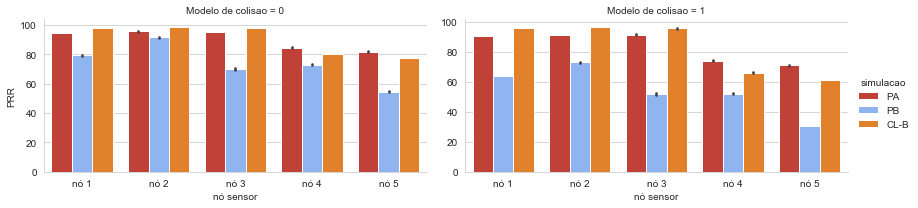

In [14]:
# df = DATA
select = (DATA['simulacao'] == PA) | (DATA['simulacao'] == PB) | (DATA['simulacao'] == BINOMIAL) 
df = DATA[select]


grid = sns.catplot(x='nó sensor',
               y='PRR',
               hue='simulacao',
               col='Modelo de colisao',
               data=df,
               height=3,
               palette=colorMAP,
               sharey=False,
               aspect=2,
               ci=95.0,
               kind='bar'
              )
# sns.barplot(x="day", y="total_bill", data=tips)

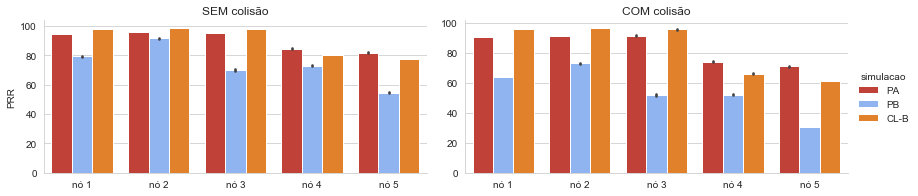

In [9]:
axes = grid.axes.flatten()

axes[0].set_title("SEM colisão")
axes[1].set_title("COM colisão")

axes[0].set_xlabel('')
axes[1].set_xlabel('')

axes[0].get_figure()

In [10]:
# select = (DATA['simulacao'] == 'p=0.7') & (DATA['node'] == 'node 5')
# df = DATA[select]

# df.describe()

Text(0.5, 1.0, 'Cenário sem colisão')

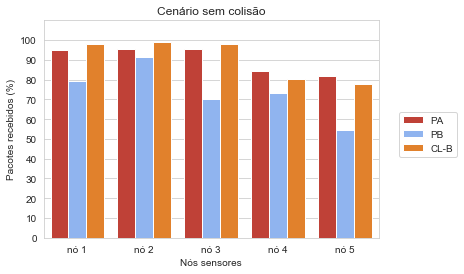

In [11]:
select = (DATA['simulacao'] == PA) | (DATA['simulacao'] == PB) | (DATA['simulacao'] == BINOMIAL)
df = DATA[select & (DATA['Modelo de colisao'] == 0)].copy()

axes = sns.barplot(x='nó sensor',
                   y='PRR',
                   hue='simulacao',
                   data=df,
                   palette=colorMAP,
                   ci=None
                   )
axes.set_xlabel('Nós sensores')
axes.set_ylabel('Pacotes recebidos (%)')
axes.set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
axes.set(ylim=(0,110))
plt.legend(bbox_to_anchor=(1.25,0.6))
plt.title('Cenário sem colisão')

In [12]:
df.tail()

,Modelo de colisao,repeticao,simulacao,nó sensor,PRR
10495,0,95,CL-B,nó 5,79.0239
10496,0,96,CL-B,nó 5,77.4103
10497,0,97,CL-B,nó 5,78.0637
10498,0,98,CL-B,nó 5,78.3409
10499,0,99,CL-B,nó 5,75.7402


Text(0.5, 1.0, 'Cenário com colisão')

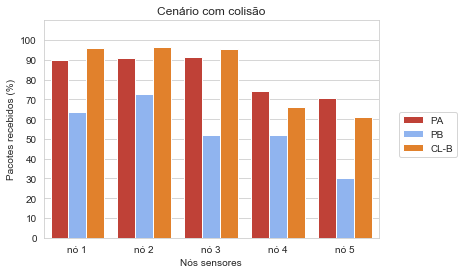

In [13]:
select = (DATA['simulacao'] == PA) | (DATA['simulacao'] == PB) | (DATA['simulacao'] == BINOMIAL)
df = DATA[select & (DATA['Modelo de colisao'] == 1)]

axes = sns.barplot(x='nó sensor',
                   y='PRR',
                   hue='simulacao',
                   data=df,
                   palette=colorMAP,
                   ci=None
                   )
axes.set_xlabel('Nós sensores')
axes.set_ylabel('Pacotes recebidos (%)')
axes.set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
axes.set(ylim=(0,110))
plt.legend(bbox_to_anchor=(1.25,0.6))
plt.title('Cenário com colisão')